<a href="https://colab.research.google.com/github/IamGrimbo/OSIRV_project/blob/main/get_started_with_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation Using TensorFlow Keras

### Semantic segmentation can be defined as the process of pixel-level image classification into two or more Object classes. It differs from image classification entirely, as the latter performs image-level classification. For instance, consider an image that consists mainly of a zebra, surrounded by grass fields, a tree and a flying bird. Image classification tells us that the image belongs to the ‘zebra’ class. It can not tell where the zebra is or what its size or pose is. But, semantic segmentation of that image may tell that there is a zebra, grass field, a bird and a tree in the given image (classifies parts of an image into separate classes). And it tells us which pixels in the image belong to which class!


# Import necessary frameworks, libraries and modules

In [ ]:
# for path related functionalities
import os
# for array operations
import numpy as np
# tensorflow framework
import tensorflow as tf
# keras API for deep learning
from tensorflow import keras
# for image visulaizations
import matplotlib.pyplot as plt
# for legends and other supporting functionalities
import matplotlib as mpl
# for viewing iteration status
from tqdm import tqdm

# Download and prepare data

### This dataset has 1000 images of people (one person per image). There are 1000 masks corresponding to those original images. Label images have 59 segmented classes corresponding to classes such as hair, bag, shirt, shoes, skin, sunglasses and cap.

In [11]:
# a list to collect paths of 1000 images
image_path = []
for root, dirs, files in os.walk('../content/Data sources/People Clothing Segmentation/png_images'):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

1000

In [13]:
# a list to collect paths of 1000 masks
mask_path = []
for root, dirs, files in os.walk('../content/Data sources/People Clothing Segmentation/png_masks'):
    #iterate over 1000 masks
    for file in files:
        # obtain the path
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)
len(mask_path)

1000

In [14]:
print(image_path[:5])

['../content/Data sources/People Clothing Segmentation/png_images/img_0068.png', '../content/Data sources/People Clothing Segmentation/png_images/img_0027.png', '../content/Data sources/People Clothing Segmentation/png_images/img_0673.png', '../content/Data sources/People Clothing Segmentation/png_images/img_0634.png', '../content/Data sources/People Clothing Segmentation/png_images/img_0305.png']


In [15]:
print(mask_path[:5])

['../content/Data sources/People Clothing Segmentation/png_masks/seg_0255.png', '../content/Data sources/People Clothing Segmentation/png_masks/seg_0697.png', '../content/Data sources/People Clothing Segmentation/png_masks/seg_0288.png', '../content/Data sources/People Clothing Segmentation/png_masks/seg_0266.png', '../content/Data sources/People Clothing Segmentation/png_masks/seg_0141.png']


# Images are unsorted in the dataset by default. We must sort them by their file names to obtain the right image-mask pairs.

In [16]:
image_path.sort()
mask_path.sort()

### Read and decode the images and masks; store them in separate lists

In [17]:
# create a list to store images
images = []
# iterate over 1000 image paths
for path in tqdm(image_path):
    # read file
    file = tf.io.read_file(path)
    # decode png file into a tensor
    image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    # append to the list
    images.append(image)

# create a list to store masks
masks = []
# iterate over 1000 mask paths
for path in tqdm(mask_path):
    # read the file
    file = tf.io.read_file(path)
    # decode png file into a tensor
    mask = tf.image.decode_png(file, channels=1, dtype=tf.uint8)
    # append mask to the list
    masks.append(mask)

100%|██████████| 1000/1000 [00:02<00:00, 482.26it/s]


### How many images and masks are there?

In [ ]:
len(images), len(masks)

(0, 0)

### Sample few images and visualize

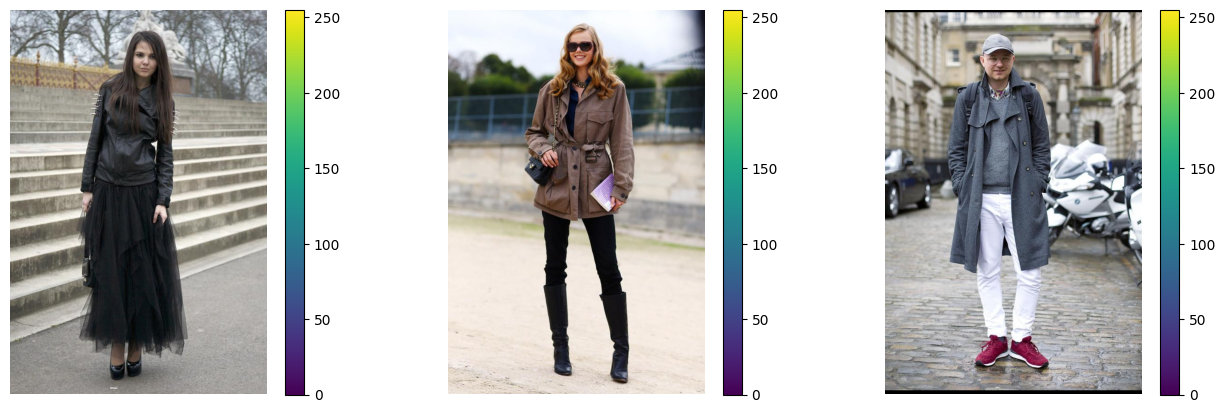

In [18]:
plt.figure(figsize=(16,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')
plt.show()

### Sample corresponding masks and visualize

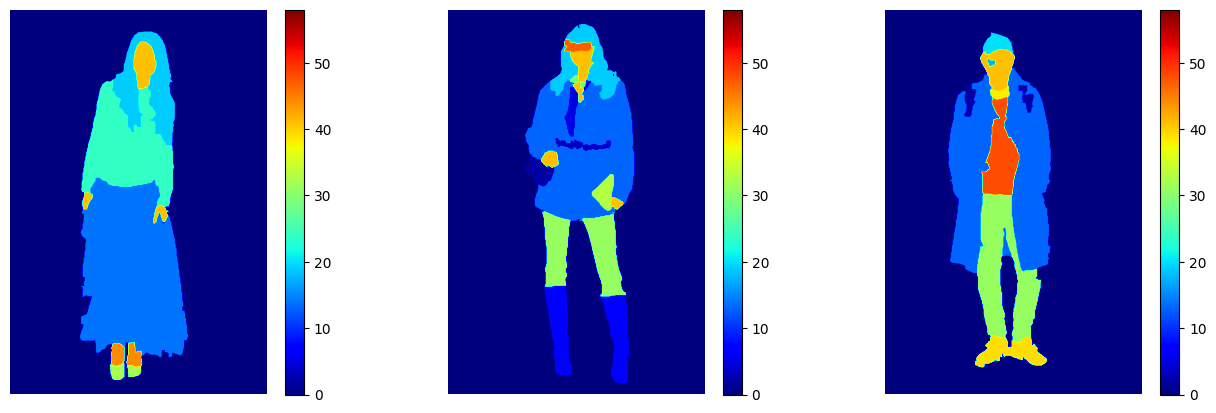

In [19]:
# Define a normalizer that can be applied while visualizing masks to have a consistency
# min class value is 0
# max class value is 58
NORM = mpl.colors.Normalize(vmin=0, vmax=58)

# plot masks
plt.figure(figsize=(16,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap='jet', norm=NORM)
    plt.colorbar()
    plt.axis('off')
plt.show()

# Build Downstack with a Pre-trained CNN

### We have to build a computer vision model that can convert an input image into a segmented image (also called masked image or label image). Building a model from scratch and training it is not a good idea as we have very limited data for training (1000 images are insufficient for 59 unbalanced classes). So we prefer a pre-trained model through transfer learning.

### By understanding how semantic segmentation works, we can easily come up with an idea of how to choose our pre-trained model. One of the popular architectural approaches is FCNN (Fully Convolutional Neural Networks). In contrast to CNNs in image classification, where the decision head is made up of dense layers, an FCNN is made up of layers related to convolutional operations only. Because the final output is an image of a shape identical to the input image.

### An FCNN contains two parts: an encoder and a decoder. An encoder is a downstack of convolutional neural layers that extract features from the input image. A decoder is an upstack of transpose convolutional neural layers that builds the segmented image from the extracted features. The sizes of feature maps go down while downsampling (e.g. 128, 64, 32, 16, 8, 4 – in order), and they go up while upsampling (e.g. 4, 8, 16, 32, 64, 128 – in order).

### Among FCNNs, U-Net is one of the successful architectures acclaimed for its performance in Medical Image Segmentation. It encourages skip connections between a few specific-sized layers of downstack and upstack. Skip-connections yield better performance because of the truth that upstack struggles to build finer details of the image on its own during upsampling. Skip-connections bye-pass a large stack of layers to feed finer details from a downstack layer to its corresponding upstack layer.

### Find below a Typical U-Net Architecture with Skip-Connections (Source: https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/u-net-architecture.png)

![A typical U-Net Architecture with Skip-Connections (Source: https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/u-net-architecture.png)](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/u-net-architecture.png)

### Here, we wish to use the functional approach of U-Net architecture, but we will have our own architecture suitable to our task. The downstack can be a pre-trained CNN, trained for image classification (e.g. MobileNetV2, ResNet, NASNet, Inception, DenseNet, or EfficientNet). It can effectively extract the features. But, we have to build our upstack to match our classes (here, 59), build skip-connections, and train it with our data.

### We prefer a pre-trained DenseNet121 to be the downstack that can be obtained through transfer learning and build the upstack with pix2pix, a publicly available generative upstack template (it saves our time and code).

In [20]:
# Use pre-trained DenseNet121 without head
base = keras.applications.DenseNet121(input_shape=[128,128,3],
                                      include_top=False,
                                      weights='imagenet')

29084464/29084464 [==============================] - 0s 0us/step


### How many layers does this model have?

In [21]:
len(base.layers)

427

### The DenseNet121 model has 427 layers. We need to identify suitable layers whose output will be used for skip connections. Plot the entire model, along with the feature shapes.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.693966 to fit



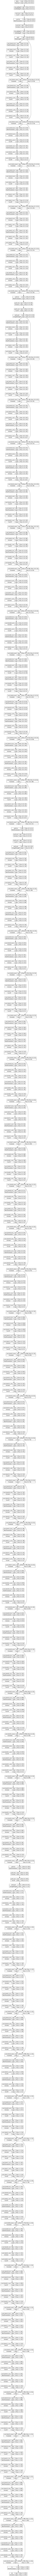

In [22]:
keras.utils.plot_model(base, show_shapes=True)

### From the above plot, we select the final ReLU activation layer for each feature map size, i.e. 4, 8, 16, 32, and 64, required for skip-connections. Write down the names of the selected ReLU layers in a list.

In [23]:
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

### Obtain the outputs of these layers.

In [24]:
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


### Build the downstack with the above layers. We use the pre-trained model as such, without any fine-tuning.

In [25]:
downstack = keras.Model(inputs=base.input,
                       outputs=skip_outputs)
# freeze the downstack layers
downstack.trainable = False

# Build Upstack

### Build the upstack using an upsampling template. Let's use pix2pix template available open-source in `tensorflow_examples` repository

In [26]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [27]:
from tensorflow_examples.models.pix2pix import pix2pix

### Build the upstack

In [28]:
# Four upstack layers for upsampling sizes
# 4->8, 8->16, 16->32, 32->64
upstack = [pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3),
          pix2pix.upsample(64,3)]

In [29]:
upstack[0].layers

# Build U-Net model with skip-connections

### Build a U-Net model by merging downstack and upstack with skip-connections.

In [30]:
# define the input layer
inputs = keras.layers.Input(shape=[128,128,3])

# downsample
down = downstack(inputs)
out = down[-1]

# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8

# upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])

# define the final transpose conv layer
# image 128 by 128 with 59 classes
out = keras.layers.Conv2DTranspose(59, 3,
                                  strides=2,
                                  padding='same',
                                  )(out)
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

### Let's plot our model

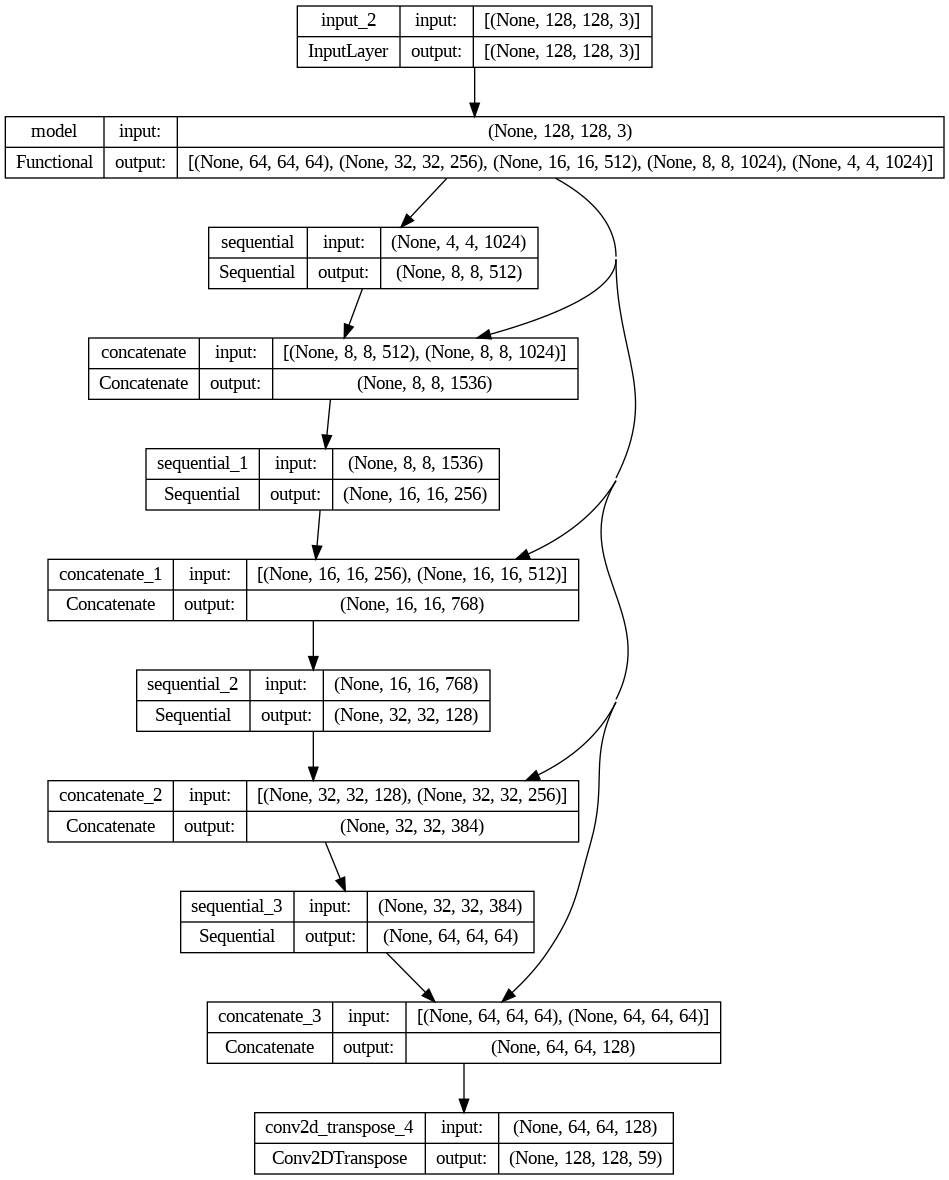

In [31]:
keras.utils.plot_model(unet, show_shapes=True)

# Data Preprocessing

In [32]:
images[0].shape, masks[0].shape

(TensorShape([825, 550, 3]), TensorShape([825, 550, 1]))

### Resize data as the model expects.

In [33]:
def resize_image(image):
    # scale the image
    image = tf.cast(image, tf.float32)
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image

def resize_mask(mask):
    # resize the mask
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask

In [34]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
len(X), len(y)

(1000, 1000)

In [35]:
images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

(tf.uint8, tf.uint8, tf.float32, tf.uint8)

### Visualize a resized image and a resized mask

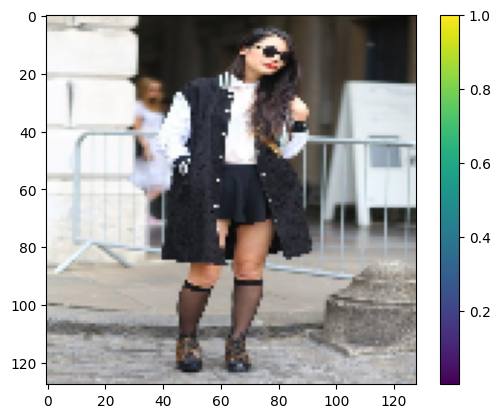

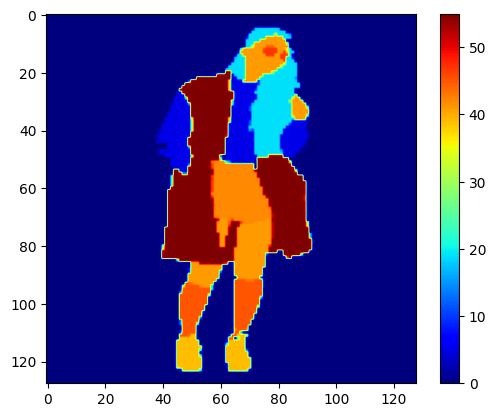

In [36]:
# plot an image
plt.imshow(X[0])
plt.colorbar()
plt.show()

#plot a mask
plt.imshow(y[0], cmap='jet')
plt.colorbar()
plt.show()

# Split Data for training and validation

### We split data into training and validation set in 80/20 ratio. We develop TensorFlow Dataset objects for train and validation sets to ease further processing and data handling.

In [37]:
from sklearn.model_selection import train_test_split
# split data into 80/20 ratio
train_X, val_X,train_y, val_y = train_test_split(X, y, test_size=0.2,
                                                      random_state=0
                                                     )
# develop tf Dataset objects
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

# verify the shapes and data types
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

# Data Augmentation

### We have less data (just 800 examples in training set) that is not enough for deep learning. Hence we should increase the amount of training data by performing data augmentations. Define Functions for data augmentation.

In [38]:
def brightness(img, mask):
    # adjust brightness of image
    # don't alter in mask
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    # adjust gamma of image
    # don't alter in mask
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    # adjust hue of image
    # don't alter in mask
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    # crop both image and mask identically
    img = tf.image.central_crop(img, 0.7)
    # resize after cropping
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    # resize afer cropping
    mask = tf.image.resize(mask, (128,128))
    # cast to integers as they are class numbers
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    # flip both image and mask identically
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    # flip both image and mask identically
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    # rotate both image and mask identically
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

### Perform data augmentation with original training set and concatenate with enlarged training set. Do not perform data augmentation with validation set. With 7 augmentation functions and 800 input examples, we can get 7*800 = 5600 new examples. Including original examples, we get 5600+800 = 6400 examples for training. That sounds good!

In [39]:
# zip images and masks
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

# concatenate every new augmented sets
train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

### Batch datasets as our SGD based optimizer would expect, and prefetch to have memory efficient training

In [40]:
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

In [41]:
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

# Check for Model and Data compatibility

### Can our data fit into our model? Is the shape, batch size and everything okay? Check compatibility by inferencing with the untrained model.

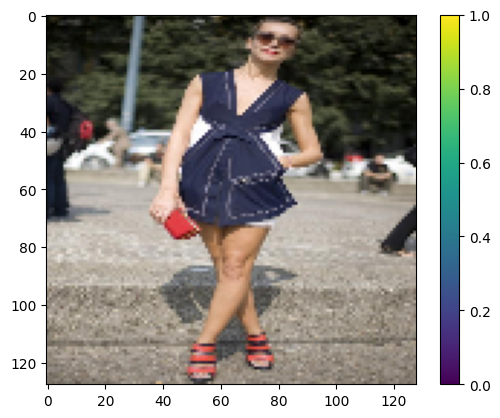

In [43]:
# infer on train dataset
example = next(iter(train))
preds = unet(example[0])
# visualize an image
plt.imshow(example[0][60])
plt.colorbar()
plt.show()

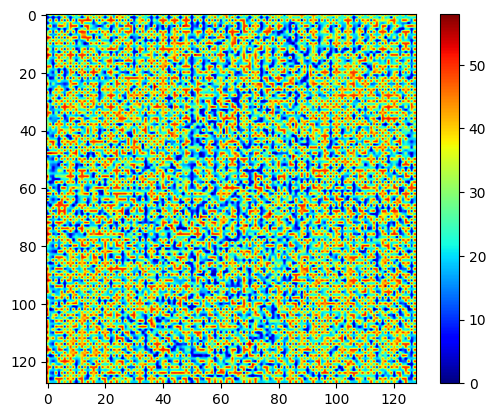

In [44]:
# visualize the predicted mask
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0], cmap='jet', norm=NORM)
plt.colorbar()

### Compile the model with the RMSprop optimizer, a low learning rate, the accuracy metric, and the sparse categorical cross entropy loss function

In [45]:
def Compile_Model():
    unet.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(lr=0.001),
            metrics=['accuracy'])
Compile_Model()

# Training and Fine-tuning

### Trainable part of our model is very small with fewer parameters. Hence we can train the model for more epochs quickly. However, version 8 of this notebook suggested that the model hardly learnt anything after 50 epochs (which was trained for 200 epochs). So we try train the model for 50 epochs by freezing the pre-trained model and unfreezing afterwards.

In [46]:
hist_1 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=50,
               verbose=2)

Epoch 1/50
12/12 - 229s - loss: 3.0017 - accuracy: 0.5794 - val_loss: 3.6003 - val_accuracy: 0.7584 - 229s/epoch - 19s/step
Epoch 2/50
12/12 - 224s - loss: 1.7964 - accuracy: 0.7656 - val_loss: 3.0609 - val_accuracy: 0.7638 - 224s/epoch - 19s/step
Epoch 3/50
12/12 - 197s - loss: 1.3402 - accuracy: 0.7711 - val_loss: 2.6190 - val_accuracy: 0.7675 - 197s/epoch - 16s/step
Epoch 4/50
12/12 - 211s - loss: 1.3982 - accuracy: 0.7015 - val_loss: 2.4868 - val_accuracy: 0.7633 - 211s/epoch - 18s/step
Epoch 5/50
12/12 - 212s - loss: 1.2512 - accuracy: 0.7167 - val_loss: 1.9320 - val_accuracy: 0.7733 - 212s/epoch - 18s/step
Epoch 6/50
12/12 - 198s - loss: 1.0795 - accuracy: 0.7466 - val_loss: 1.5633 - val_accuracy: 0.7740 - 198s/epoch - 17s/step
Epoch 7/50
12/12 - 212s - loss: 1.0244 - accuracy: 0.7638 - val_loss: 1.4094 - val_accuracy: 0.7779 - 212s/epoch - 18s/step
Epoch 8/50
12/12 - 215s - loss: 0.9594 - accuracy: 0.7726 - val_loss: 1.2306 - val_accuracy: 0.7763 - 215s/epoch - 18s/step
Epoch 9/

### Make some prediction and visualize them to evaluate the model qualitatively.

2/2 [==============================] - 11s 3s/step


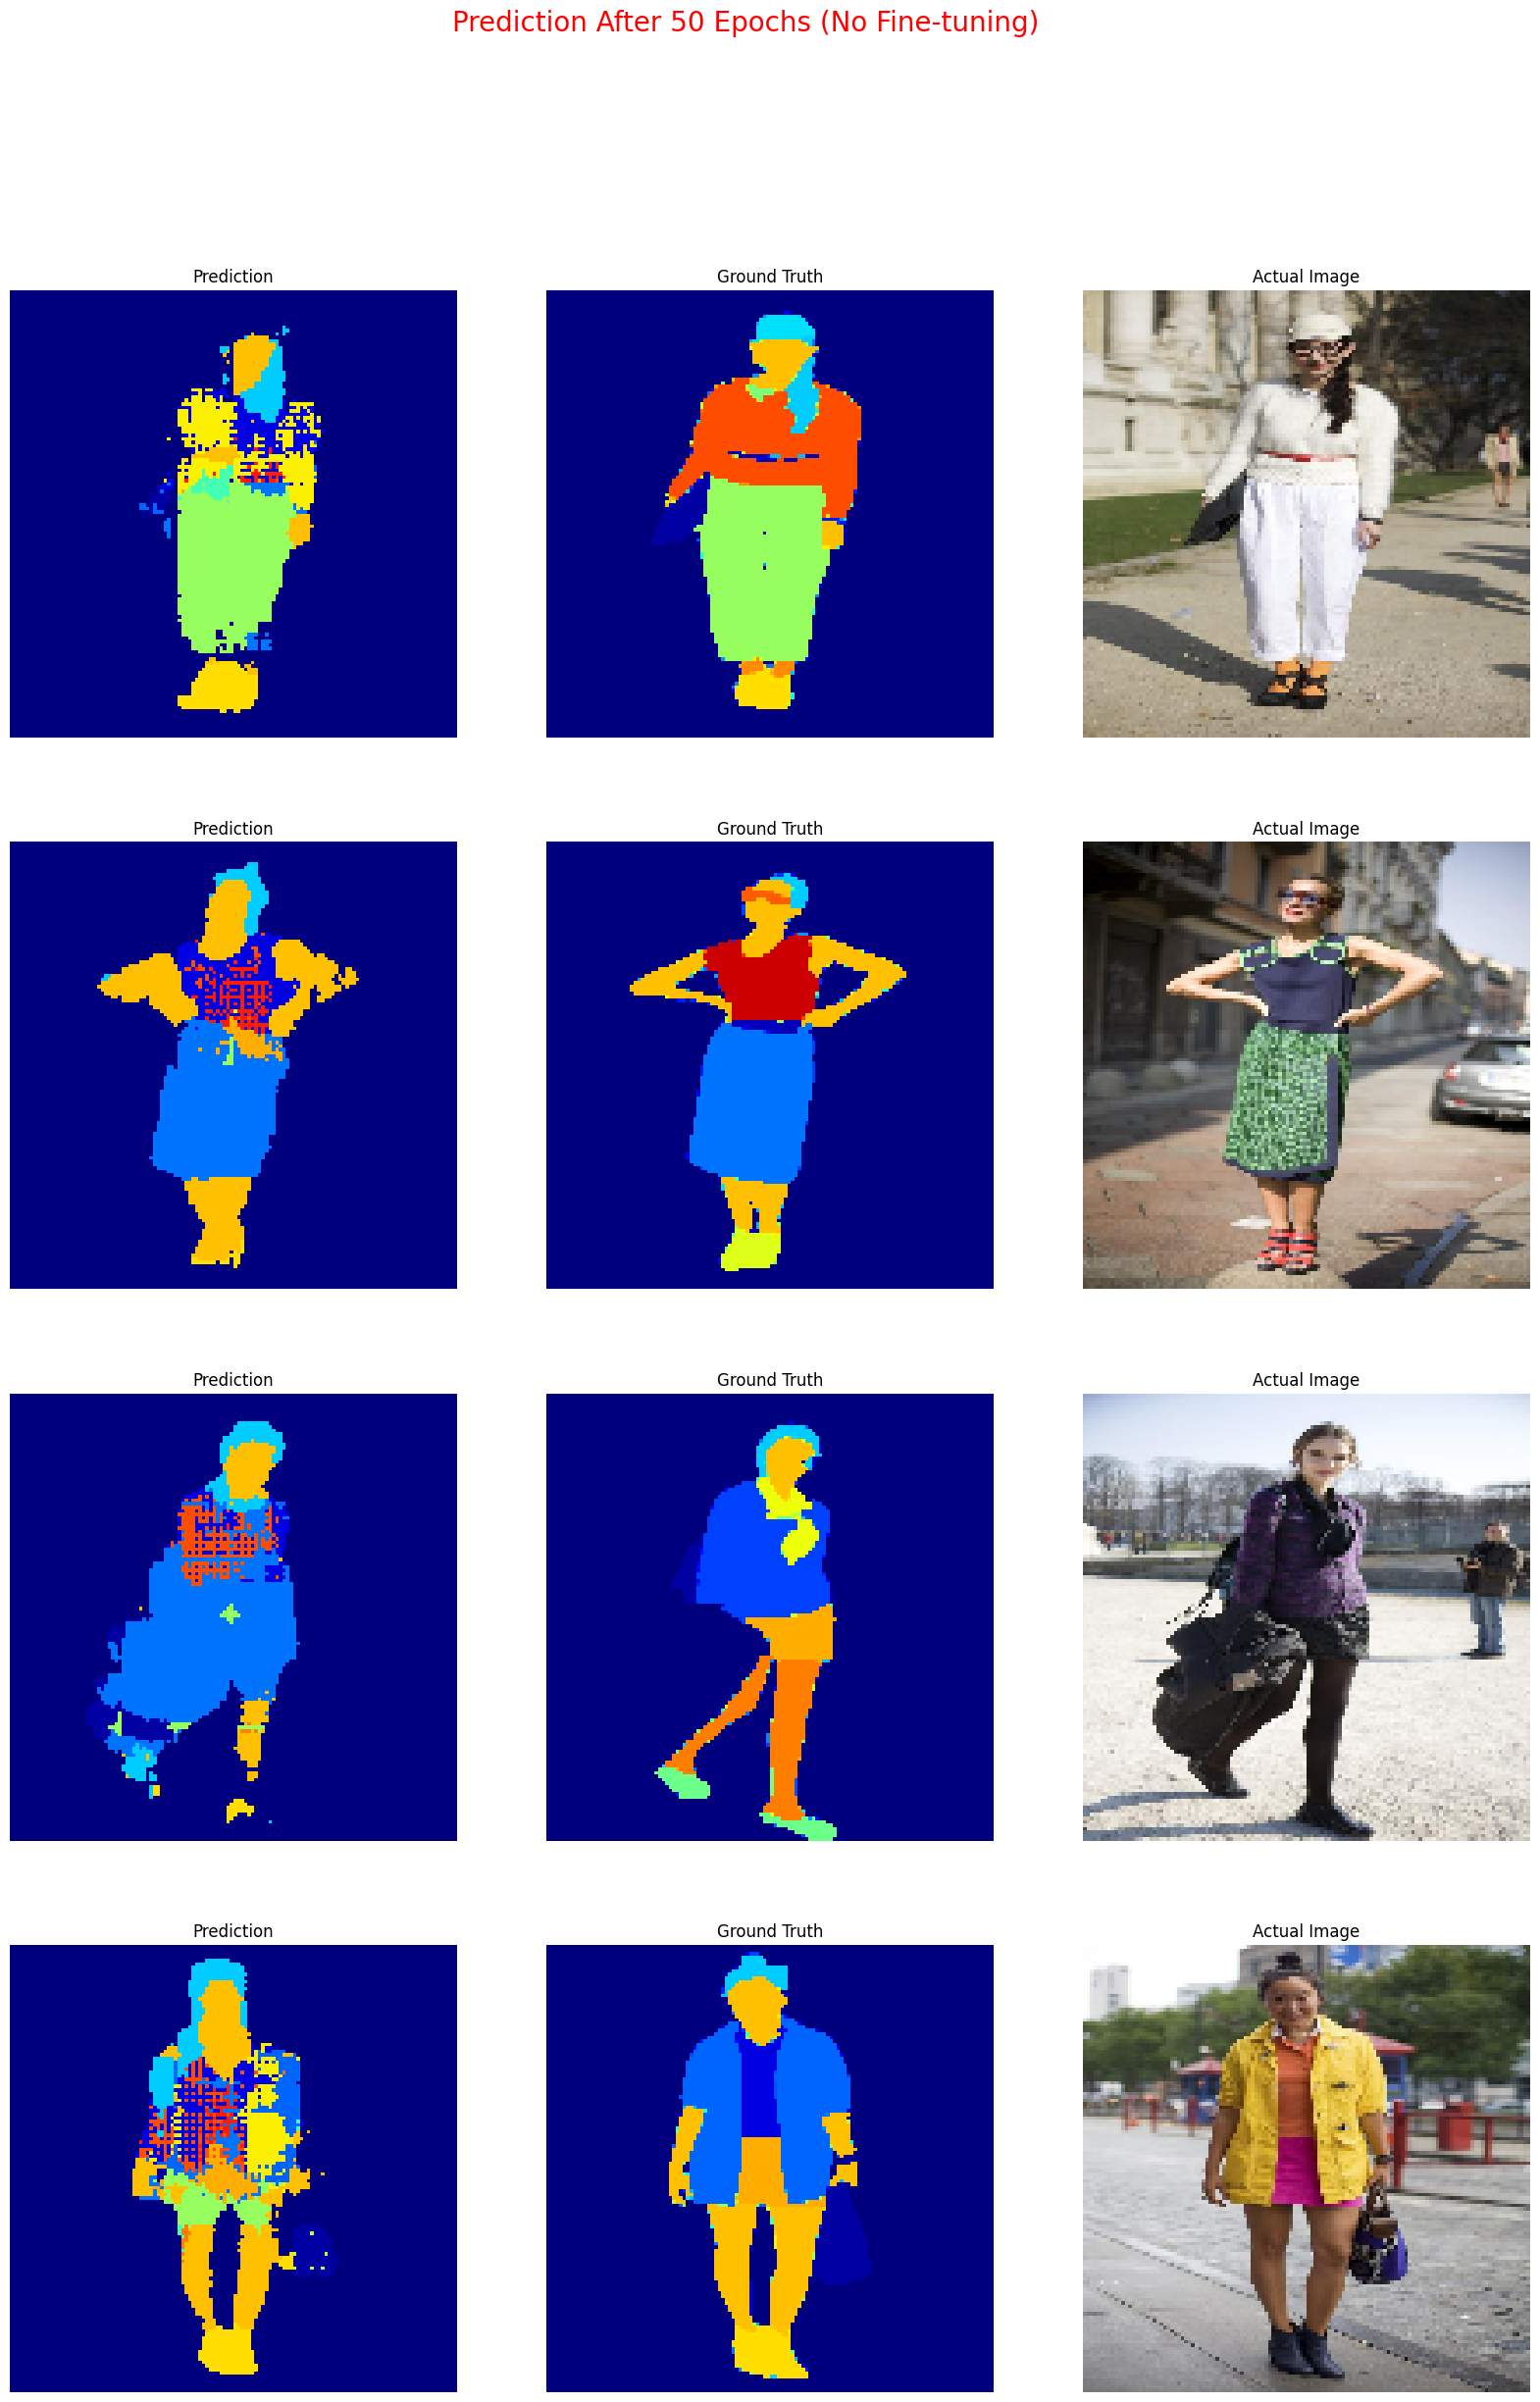

In [47]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Prediction After 50 Epochs (No Fine-tuning)', color='red', size=20)
plt.show()

### Fine-tune the model after 50 epochs. Unfreeze the downstack, compile the model once again. Re-train it for 100 more epochs.

In [ ]:
downstack.trainable = True
# compile again
Compile_Model()
# train from epoch 51 to 150
hist_2 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=150, initial_epoch = 50,
               verbose = 2
                 )

Epoch 51/150
12/12 - 388s - loss: 0.5595 - accuracy: 0.8500 - val_loss: 0.6869 - val_accuracy: 0.8250 - 388s/epoch - 32s/step
Epoch 52/150
12/12 - 347s - loss: 0.5002 - accuracy: 0.8632 - val_loss: 0.6475 - val_accuracy: 0.8328 - 347s/epoch - 29s/step
Epoch 53/150
12/12 - 345s - loss: 0.4470 - accuracy: 0.8782 - val_loss: 0.7634 - val_accuracy: 0.8201 - 345s/epoch - 29s/step
Epoch 54/150
12/12 - 340s - loss: 0.6839 - accuracy: 0.8237 - val_loss: 0.6787 - val_accuracy: 0.8248 - 340s/epoch - 28s/step
Epoch 55/150
12/12 - 344s - loss: 0.6691 - accuracy: 0.8292 - val_loss: 0.6608 - val_accuracy: 0.8386 - 344s/epoch - 29s/step
Epoch 56/150
12/12 - 346s - loss: 0.5800 - accuracy: 0.8487 - val_loss: 0.7960 - val_accuracy: 0.8211 - 346s/epoch - 29s/step
Epoch 57/150
12/12 - 340s - loss: 0.5616 - accuracy: 0.8496 - val_loss: 0.7865 - val_accuracy: 0.8118 - 340s/epoch - 28s/step
Epoch 58/150
12/12 - 319s - loss: 0.5418 - accuracy: 0.8529 - val_loss: 0.6689 - val_accuracy: 0.8291 - 319s/epoch - 2

# Prediction

### The model is trained. Make prediction and visualize the output. Compare the results with groundtruth masks

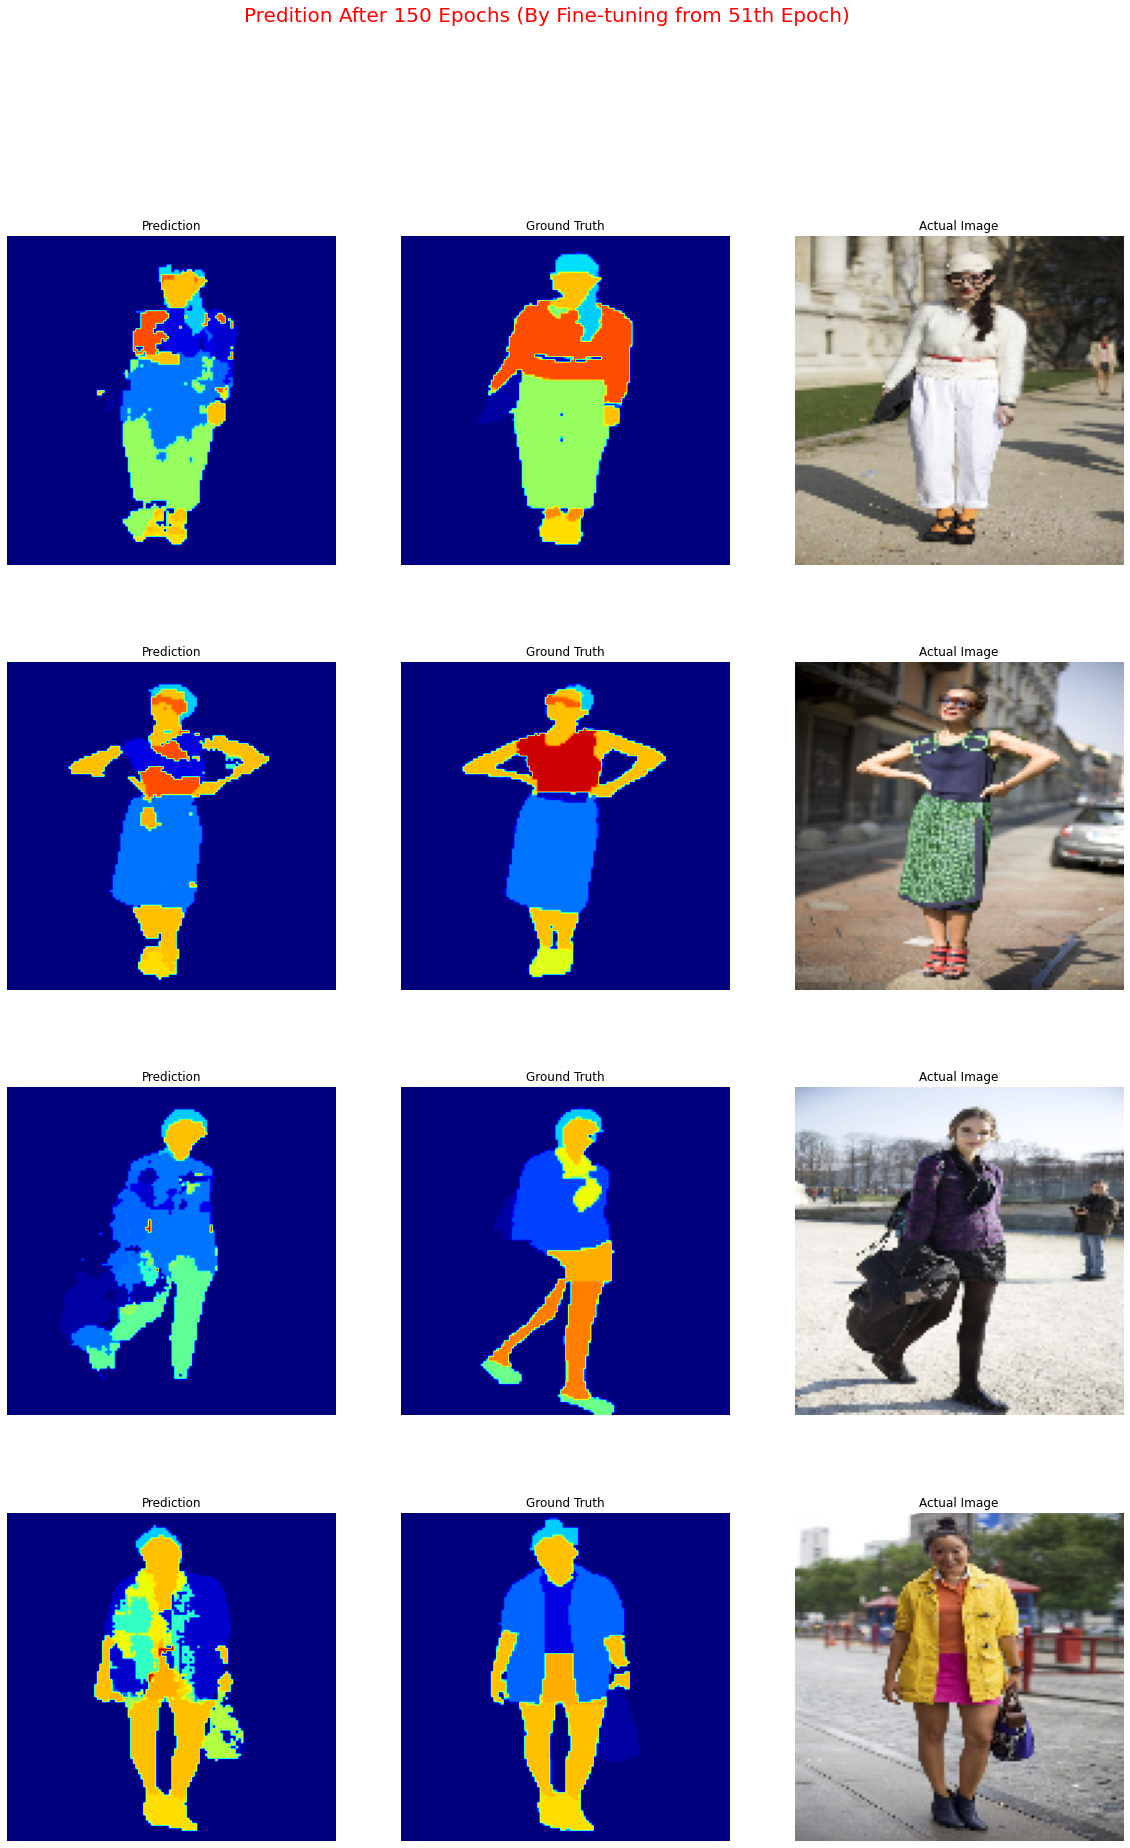

In [ ]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,30))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Prediction After 150 Epochs (By Fine-tuning from 51th Epoch)', color='red', size=20)
plt.show()

### Fine-tuning has improved the model performance significantly!

# Performance Curves

### Plot the performance curves to understand how the model learnt on the data

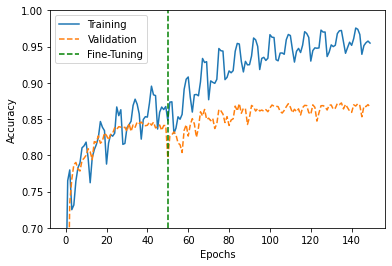

In [ ]:
history_1 = hist_1.history
acc=history_1['accuracy']
val_acc = history_1['val_accuracy']

history_2 = hist_2.history
acc.extend(history_2['accuracy'])
val_acc.extend(history_2['val_accuracy'])

plt.plot(acc[:150], '-', label='Training')
plt.plot(val_acc[:150], '--', label='Validation')
plt.plot([50,50],[0.7,1.0], '--g', label='Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7,1.0])
plt.legend()
plt.show()

### Model performance can be improved by tuning hyper-parameters and increasing the training data with few more data augmentation functions.

### Thank you for your time!